In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [16]:
#Loading datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [17]:
print("Customers Dataset Info:")
print(customers.info())
print("\nProducts Dataset Info:")
print(products.info())
print("\nTransactions Dataset Info:")
print(transactions.info())

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   C

In [18]:
print("\nMissing Values in Each Dataset:")
print("Customers:\n", customers.isnull().sum())
print("Products:\n", products.isnull().sum())
print("Transactions:\n", transactions.isnull().sum())


Missing Values in Each Dataset:
Customers:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
Products:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
Transactions:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [19]:
# Convert date columns to datetime
def convert_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

merged_data = convert_to_datetime(merged_data, "TransactionDate")
customers = convert_to_datetime(customers, "SignupDate")

In [21]:
print("Summary of Transactions:\n", transactions.describe())
print("Unique Regions:\n", customers["Region"].unique())

Summary of Transactions:
           Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000
Unique Regions:
 ['South America' 'Asia' 'North America' 'Europe']


In [8]:
merged_data = transactions.merge(customers, on='CustomerID', how='left').merge(products, on='ProductID', how='left')

In [22]:
# 1. Customer Segmentation
customer_summary = merged_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_spent=("TotalValue", "mean"),
    total_transactions=("TransactionID", "count")
).reset_index()

bins = [0, 500, 2000, customer_summary['total_spent'].max()]
labels = ["Low Spenders", "Moderate Spenders", "High Spenders"]
customer_summary["SpendingSegment"] = pd.cut(customer_summary["total_spent"], bins=bins, labels=labels)

print("Customer Segmentation:\n", customer_summary.head())

Customer Segmentation:
   CustomerID  total_spent  avg_spent  total_transactions    SpendingSegment
0      C0001      3354.52    670.904                   5      High Spenders
1      C0002      1862.74    465.685                   4  Moderate Spenders
2      C0003      2725.38    681.345                   4      High Spenders
3      C0004      5354.88    669.360                   8      High Spenders
4      C0005      2034.24    678.080                   3      High Spenders


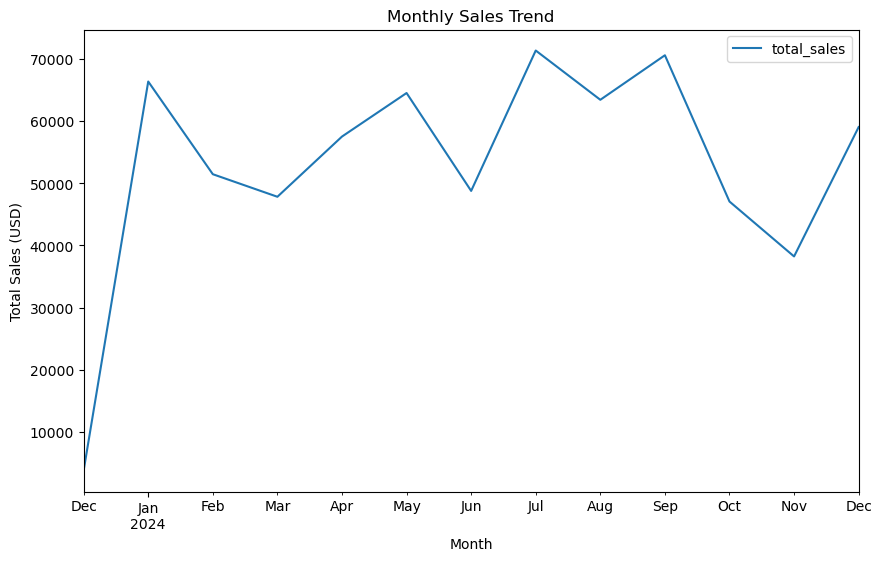

In [23]:
merged_data["TransactionMonth"] = merged_data["TransactionDate"].dt.to_period("M")
monthly_sales = merged_data.groupby("TransactionMonth").agg(
    total_sales=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count")
).reset_index()

monthly_sales.plot(x="TransactionMonth", y="total_sales", kind="line", figsize=(10, 6), title="Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (USD)")
plt.show()

In [24]:
# 3. Anomaly Detection in Sales Patterns
monthly_sales["z_score"] = zscore(monthly_sales["total_sales"])
anomalies = monthly_sales[(monthly_sales["z_score"] > 2) | (monthly_sales["z_score"] < -2)]
print("Sales anomalies detected:\n", anomalies)

Sales anomalies detected:
   TransactionMonth  total_sales  total_transactions   z_score
0          2023-12      3769.52                   4 -2.865505


Top Products by Revenue:
               ProductName  total_revenue  total_quantity
9   ActiveWear Smartwatch       39096.97             100
47   SoundWave Headphones       25211.64              97
52        SoundWave Novel       24507.90              58
4       ActiveWear Jacket       22712.56              76
6          ActiveWear Rug       22314.43              79


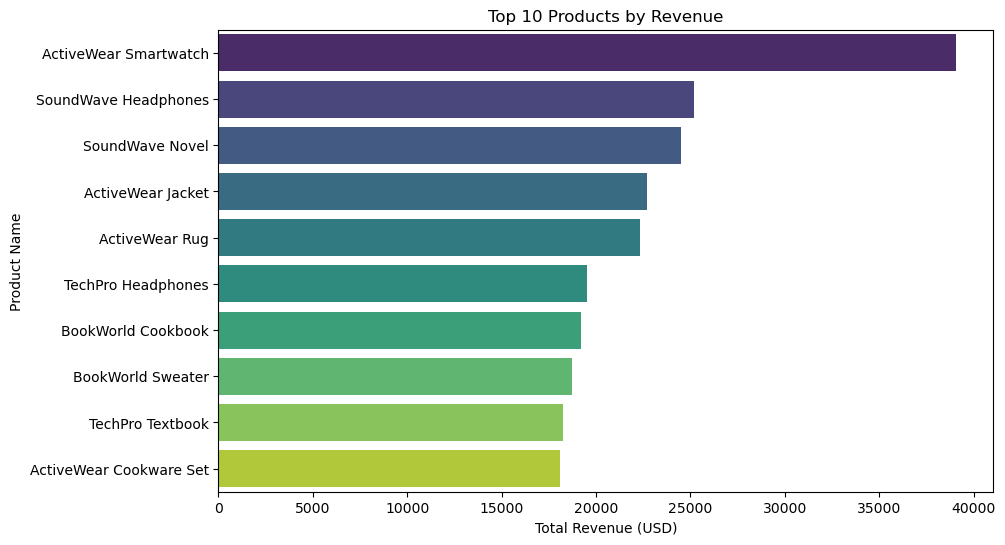

In [25]:
# 4. Top Products by Revenue
product_revenue = merged_data.groupby("ProductName").agg(
    total_revenue=("TotalValue", "sum"),
    total_quantity=("Quantity", "sum")
).reset_index().sort_values(by="total_revenue", ascending=False)

print("Top Products by Revenue:\n", product_revenue.head())

plt.figure(figsize=(10, 6))
sns.barplot(
    x=product_revenue["total_revenue"].head(10),
    y=product_revenue["ProductName"].head(10),
    palette="viridis"
)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Product Name")
plt.show()

Sales Trends by Region and Category:
 Category          Books  Clothing  Electronics  Home Decor
Region                                                    
Asia           33119.03  49353.09     35658.15    33944.70
Europe         47464.42  36335.59     41562.60    40892.02
North America  41811.99  38038.49     44716.43    27746.49
South America  69752.03  42443.49     58846.32    48310.72


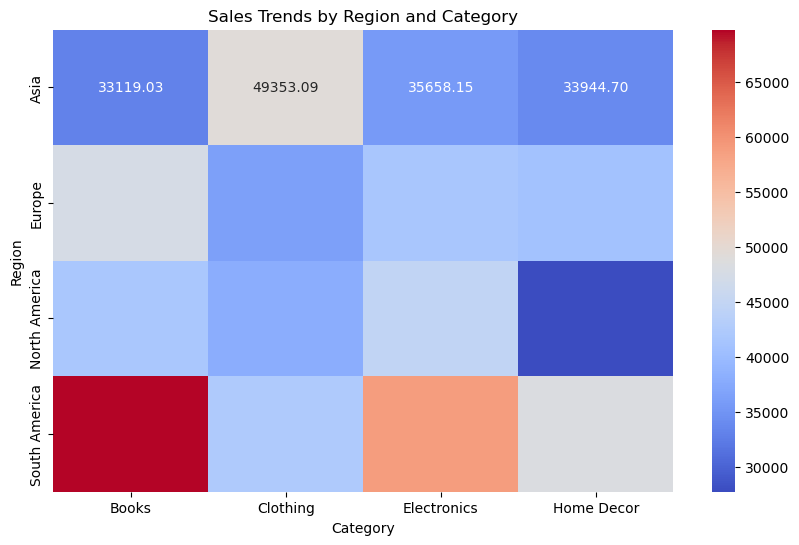

In [26]:
# 5. Demographic Trends
region_category_sales = merged_data.groupby(["Region", "Category"]).agg(
    total_sales=("TotalValue", "sum"),
    total_quantity=("Quantity", "sum")
).reset_index()

pivot_data = region_category_sales.pivot(index="Region", columns="Category", values="total_sales")
print("Sales Trends by Region and Category:\n", pivot_data)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Sales Trends by Region and Category")
plt.show()